# Temat: Klasyfikacja rodzajów gestów dłoni na podstawie nagranej aktywności mięśni

### Autorzy
Damian Kacperski

Grupa 3, Czwartek 8:15 - 10:00

## Opis problemu

Celem projektu jest sklasyfikowanie czterech rodzaji gestów dłoni: kamienia (ściśniętej pięści), papieru (prostej ręki), nożyc (wyprostowany tylko palec środkowy i wskazujący) oraz znaku OK (wyprostowany kciuk). Analizę należy przeprowadzić na podstawie 8 odczytów z 8 czujników EMG aktywności ludzkich mięśni.

## Wczytanie danych

In [2]:
import pandas as pd

path = r'./data/'
dt = [pd.read_csv(path + str(file) + '.csv', header=None) for file in range(0, 4)]

columns = ['r' + str(reading) + '_s' + str(sensor) for reading in range(0, 8) for sensor in range(0, 8)] + ['gesture']
for dta in dt:
    dta.columns = columns

data = pd.concat(dt, sort=False)

data.head()

,r0_s0,r0_s1,r0_s2,r0_s3,r0_s4,r0_s5,r0_s6,r0_s7,r1_s0,r1_s1,...,r6_s7,r7_s0,r7_s1,r7_s2,r7_s3,r7_s4,r7_s5,r7_s6,r7_s7,gesture
0,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,-28.0,61.0,4.0,8.0,5.0,4.0,-7.0,-59.0,16.0,0
1,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
2,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
3,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
4,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0


## Podstawowa analiza danych

### Określenie liczby obiektów

In [3]:
objects_number = len(data.index)

print('Liczba obiektów:', objects_number)

Liczba obiektów: 11678


### Określenie liczby klas

In [4]:
classes_number = len(data['gesture'].unique())

print('Liczba klas:', classes_number)

Liczba klas: 4


### Określenie zakresów zmienności poszczególnych atrybutów

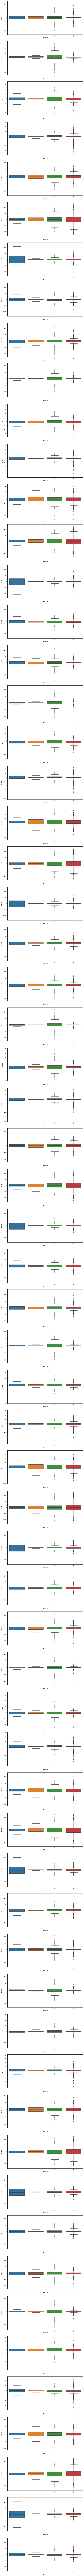

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10, 350), dpi = 80)
for r in range(0, 8):
    for s in range(0, 8):
        plt.subplot(64, 1, r*8 + (s+1))
        name = 'r' + str(r) + '_s' + str(s)
        sns.boxplot(x = "gesture", y = name, data = data)

### Określenie wartości statystycznych

In [6]:
sensors_data = data.drop(['gesture'], axis=1)
sensors_data.describe()

,r0_s0,r0_s1,r0_s2,r0_s3,r0_s4,r0_s5,r0_s6,r0_s7,r1_s0,r1_s1,...,r6_s6,r6_s7,r7_s0,r7_s1,r7_s2,r7_s3,r7_s4,r7_s5,r7_s6,r7_s7
count,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,...,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000
mean,-0.520380,-0.726837,-0.739082,-0.729748,-0.159103,-0.554890,-1.272649,-0.661843,-0.665953,-0.654222,...,-1.622452,-0.932694,-0.836958,-0.740623,-0.768710,-0.705343,-0.146686,-0.374807,-1.449306,-0.609094
std,18.566709,11.766878,4.989944,7.441675,17.850402,25.809528,25.089972,15.408896,18.123854,11.841260,...,25.293001,15.158993,18.204465,12.005206,4.969758,7.384410,17.841479,25.551082,25.259736,15.530091
min,-116.000000,-104.000000,-33.000000,-75.000000,-121.000000,-122.000000,-128.000000,-128.000000,-110.000000,-128.000000,...,-128.000000,-128.000000,-116.000000,-128.000000,-46.000000,-74.000000,-103.000000,-128.000000,-128.000000,-124.000000
25%,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-15.000000,-6.000000,-8.000000,-9.000000,-4.000000,...,-6.000000,-8.000000,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-14.000000,-6.000000,-8.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
75%,7.000000,3.000000,2.000000,3.000000,10.000000,13.000000,4.000000,6.000000,6.000000,3.000000,...,3.000000,6.000000,6.000000,3.000000,2.000000,3.000000,10.000000,13.000000,3.000000,6.000000
max,111.000000,90.000000,34.000000,55.000000,92.000000,127.000000,127.000000,126.000000,127.000000,106.000000,...,127.000000,114.000000,127.000000,105.000000,29.000000,51.000000,110.000000,127.000000,127.000000,127.000000


### Określenie poziomu wypełnienia kolumn

In [7]:
objects_with_missing_columns = data.isna().sum().sum()

print('Liczba obiektów z brakującymi kolumnami:', objects_with_missing_columns)

Liczba obiektów z brakującymi kolumnami: 0


### Określenie ilości unikalnych danych

In [8]:
unique_data_count = len(data.drop_duplicates())

print('Ilość unikalnych danych:', unique_data_count)

Ilość unikalnych danych: 11678


Dostarczone dane składają się z 11678 obiektów, każdy obiekt jest unikalny i posiada wypełnione wszystkie kolumny tj. pierwsze 64 kolumny to informacje o 8 kolejnych odczytach z 8 czujników, a 65 kolumna to rodzaj gestu, jedna z 4 klas. Zakres zmienności jest szczególnie duży przy odczytach dla klasy "0", czyli gestu pięści, kiedy wszystkie mięśnie są aktywne, natomiast szczególnie mały dla klasy "1", czyli gestu papieru, kiedy mięśnie są rozluźnione.

## Analiza korelacji między zmiennymi

Przeanalizować korelację między zmiennymi

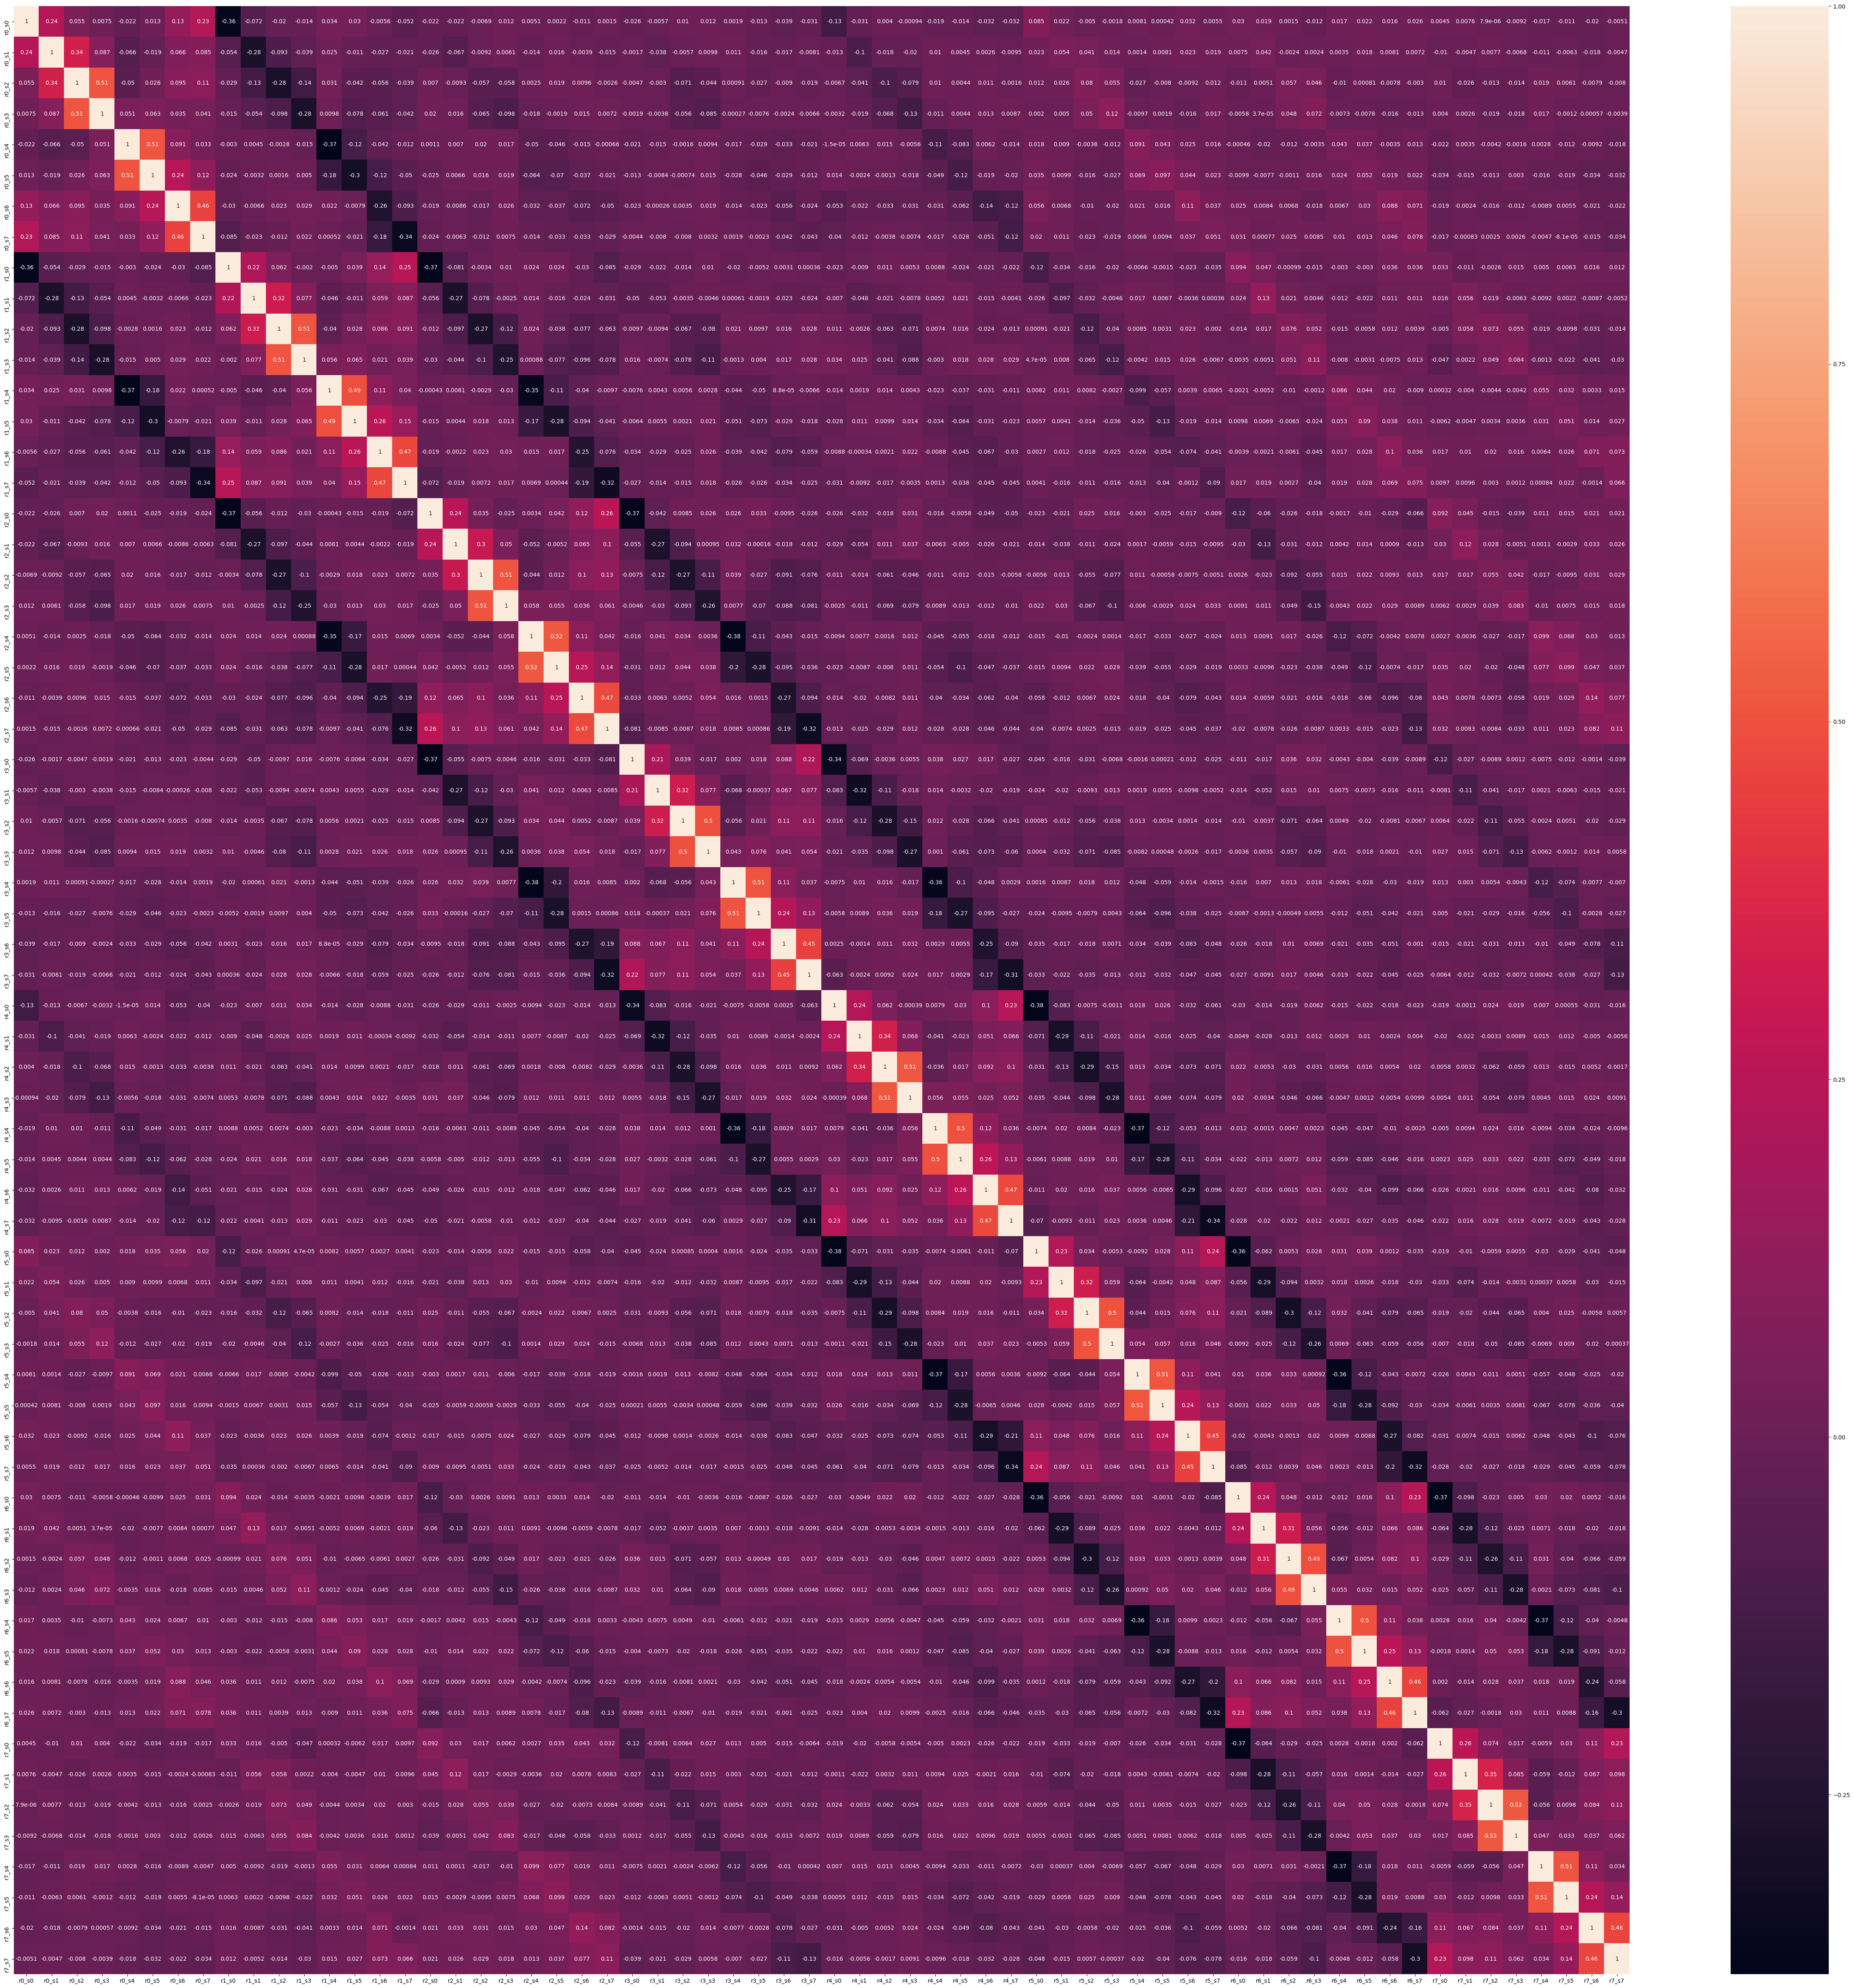

In [9]:
plt.figure(figsize = (64, 64), dpi = 100)
sns.heatmap(sensors_data.corr(), annot = sensors_data.corr())
plt.show()

Z analizy korelacji możemy odczytać, że istnieje relacja pomiędzy tymi samymi czujnikami w ramach kolejnych odczytów oraz pomiędzy różnymi czujnikami w ramach jednego odczytu. Natomast związek pomiędzy różnymi czujnikami w ramach różnych odczytów jest bardzo słaby.

## Przygotowanie danych do analizy

Dane są w pełni wypełnione dlatego nie ma potrzeby usuwania brakujących danych lub kolumn.

## Analiza podobieństwa przy pomocy algorytmów grupowania

Przeanalizować podobieństwo między danymi przy pomocy poznanych algorytmów grupowania wraz z analizą ilości grup

grupa       0  1  2  3
gesture               
0        2906  2  1  1
1        2903  0  0  0
2        2943  0  0  0
3        2922  0  0  0
grupa     0     1   2    3
gesture                   
0        19  2569  43  279
1         0  2903   0    0
2         0  2943   0    0
3         0  2922   0    0
grupa       0  1  2  3
gesture               
0        2907  1  1  1
1        2903  0  0  0
2        2943  0  0  0
3        2922  0  0  0
grupa       0    1    2    3
gesture                     
0        1661  657  394  198
1        2339  564    0    0
2        2161  782    0    0
3        1987  934    1    0


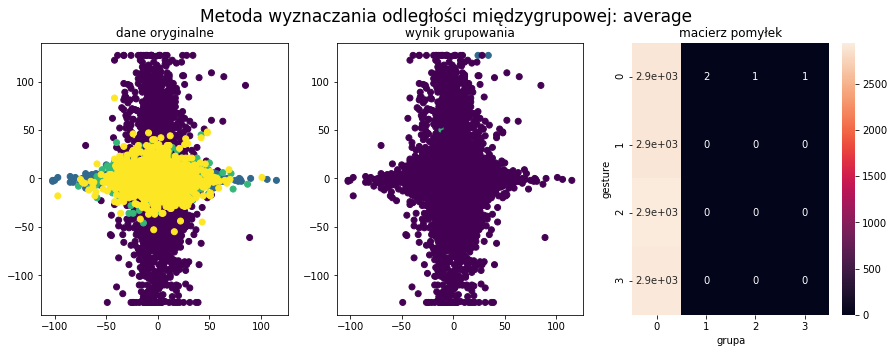

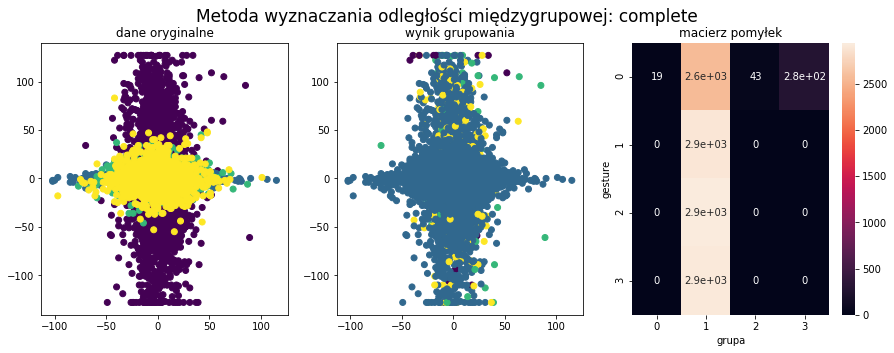

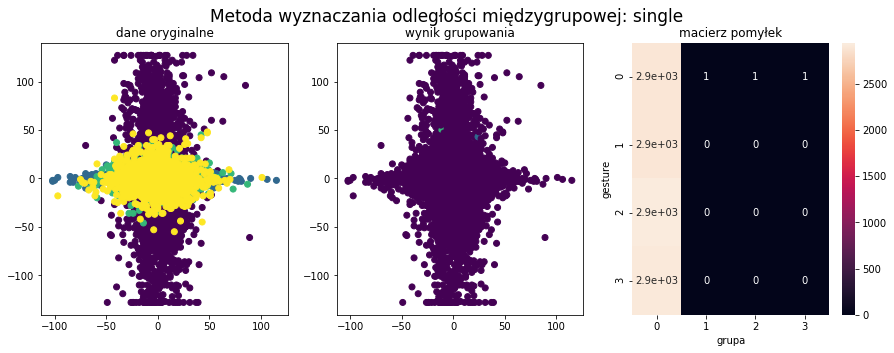

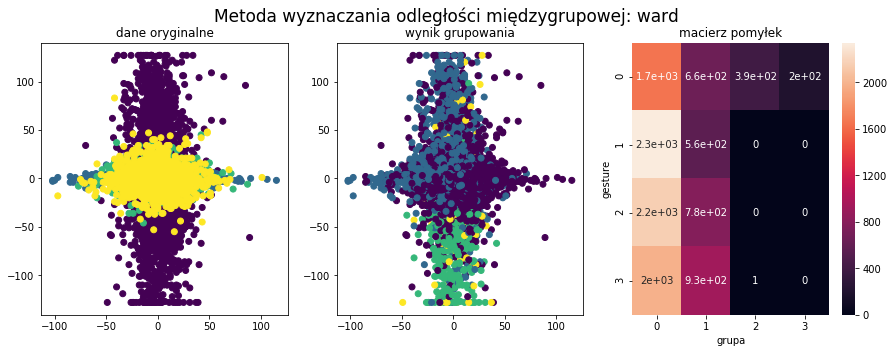

In [29]:
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster
from sklearn.cluster import AgglomerativeClustering

ile_grup = 4
sd_copy = sensors_data
attribute_1 = 'r5_s4'
attribute_2 = 'r1_s6'

klasa = data['gesture'].astype('category').cat.codes

for index, linkage in enumerate(('average', 'complete', 'single', 'ward')):
    model = AgglomerativeClustering(linkage=linkage, n_clusters=ile_grup)
    model.fit(sd_copy)
    grupa = model.labels_

    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    plt.scatter( x=data[attribute_1], y=data[attribute_2], c=klasa)
    plt.title('dane oryginalne')

    plt.subplot(1,3,2)
    sd_copy['grupa']= model.labels_
    plt.scatter( x=sensors_data[attribute_1], y=sd_copy[attribute_2], c=grupa)
    plt.title('wynik grupowania')

    plt.subplot(1,3,3)
    pomylki = pd.crosstab(data['gesture'], sd_copy['grupa'])
    print(pomylki)
    sns.heatmap(pomylki, annot = pomylki)
    plt.title('macierz pomyłek')
    
    plt.suptitle('Metoda wyznaczania odległości międzygrupowej: ' + linkage, size=17)

Analiza przy pomocy algorytmów grupowania nie przyniosła pozytywnych efektów. Spowodowane jest to tym, że dane każdej z klas mają podobne wartości i wszystkie obiekty są w bliskich odległościach. Grupowanie k-średnich również nie przyniosłoby pozytywnego efektu, ponieważ centroidy grup znajdują się praktycznie w jednym punkcie.

## Testowanie wybranych klasyfikatorów

Testujemy wybrane klasyfikatory pod kątem doboru ich parametrów

In [35]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels

Podział zbioru danych na argumenty i wyniki, podział na dane treningowe i testowe.

In [36]:
x = data.drop(['gesture'], axis=1)
x = StandardScaler().fit_transform(x)
y = data['gesture']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .30, random_state=38)

Wyświetlanie błędów

In [37]:
import numpy as np

def view_confusion_matrix(y_true, y_pred, classes,title=None, cmap=plt.cm.Greens):
    if not title:
        title="Macierz błędów"
    conf_mtx = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(conf_mtx, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(conf_mtx.shape[1]),
           yticks=np.arange(conf_mtx.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Prawdziwa klasa',
           xlabel='Przewidywana klasa')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    
    thresh = conf_mtx.max() / 2.
    
    for k in range(conf_mtx.shape[0]):
        for l in range(conf_mtx.shape[1]):
            ax.text(k, l, format(conf_mtx[k, l], fmt),
                    ha="center", va="center",
                    color="white" if conf_mtx[k, l] > thresh else "black")
            
    fig.tight_layout()
    
    return ax

### Klasyfikator KNN na podstawie 15 najbliższych

Sprawność  0.6329908675799086 

              precision    recall  f1-score   support

      kamień       0.95      0.54      0.69       906
      papier       0.52      0.95      0.67       834
      nożyce       0.84      0.26      0.40       866
          OK       0.60      0.79      0.68       898

    accuracy                           0.63      3504
   macro avg       0.72      0.64      0.61      3504
weighted avg       0.73      0.63      0.61      3504



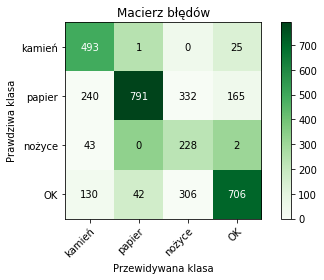

In [39]:
knn = KNeighborsClassifier(15)

knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
result = knn.score(x_test, y_test)

target_names=['kamień','papier','nożyce','OK']

print("Sprawność ", result, "\n" )
print(classification_report(y_test, y_pred, target_names=target_names))
view_confusion_matrix(y_test, y_pred, classes=target_names)

plt.show()

### Klasyfikator KNN - klasyfikacja na podstawie 100 najbliższych sąsiadów

Sprawność  0.531392694063927 

              precision    recall  f1-score   support

      kamień       0.98      0.29      0.44       906
      papier       0.46      0.98      0.63       834
      nożyce       0.72      0.10      0.17       866
          OK       0.52      0.78      0.62       898

    accuracy                           0.53      3504
   macro avg       0.67      0.54      0.47      3504
weighted avg       0.68      0.53      0.47      3504



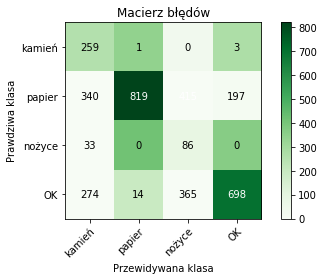

In [40]:
knn = KNeighborsClassifier(100)

knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
result = knn.score(x_test, y_test)

target_names=['kamień','papier','nożyce','OK']

print("Sprawność ", result, "\n" )
print(classification_report(y_test, y_pred, target_names=target_names))
view_confusion_matrix(y_test, y_pred, classes=target_names)

plt.show()

### Naiwny klasyfikator bayesowski 

Sprawność  0.8795662100456622 

              precision    recall  f1-score   support

      kamień       0.91      0.91      0.91       906
      papier       0.83      0.95      0.89       834
      nożyce       0.95      0.91      0.93       866
          OK       0.83      0.76      0.79       898

    accuracy                           0.88      3504
   macro avg       0.88      0.88      0.88      3504
weighted avg       0.88      0.88      0.88      3504



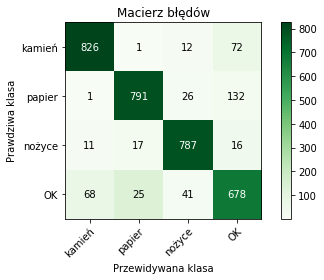

In [43]:
ncb = GaussianNB()

ncb.fit(x_train, y_train)
y_pred = ncb.predict(x_test)
result = ncb.score(x_test, y_test)

target_names=['kamień','papier','nożyce','OK']

print("Sprawność ", result, "\n" )
print(classification_report(y_test, y_pred, target_names=target_names))
view_confusion_matrix(y_test, y_pred, classes=target_names)

plt.show()

### Klasyfikator Drzewa Decyzyjnego bez ustawionej głębokości maksymalnej - kryterium 'gini'.

Sprawność:  0.773972602739726 

              precision    recall  f1-score   support

      kamień       0.89      0.83      0.86       906
      papier       0.77      0.79      0.78       834
      nożyce       0.76      0.76      0.76       866
          OK       0.69      0.72      0.70       898

    accuracy                           0.77      3504
   macro avg       0.78      0.77      0.77      3504
weighted avg       0.78      0.77      0.78      3504



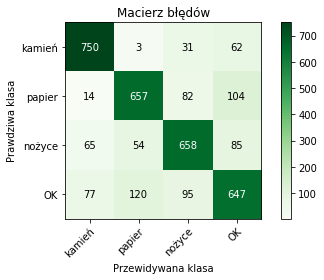

In [45]:
dtc = DecisionTreeClassifier()

dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
result = dtc.score(x_test, y_test)

target_names=['kamień','papier','nożyce','OK']

print("Sprawność: ", result, "\n" )
print(classification_report(y_test, y_pred, target_names=target_names))
view_confusion_matrix(y_test, y_pred, classes=target_names)

plt.show()

### Klasyfikator Drzewa Decyzyjnego z ustawion głębokością maksymalną - kryterium 'gini'.

Sprawność:  0.7856735159817352 

              precision    recall  f1-score   support

      kamień       0.89      0.84      0.86       906
      papier       0.77      0.82      0.80       834
      nożyce       0.76      0.76      0.76       866
          OK       0.72      0.72      0.72       898

    accuracy                           0.79      3504
   macro avg       0.79      0.79      0.79      3504
weighted avg       0.79      0.79      0.79      3504



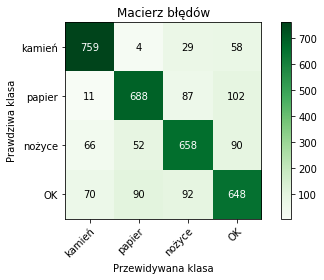

In [47]:
dtc = DecisionTreeClassifier(max_depth=25)

dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
result = dtc.score(x_test, y_test)

target_names=['kamień','papier','nożyce','OK']

print("Sprawność: ", result, "\n" )
print(classification_report(y_test, y_pred, target_names=target_names))
view_confusion_matrix(y_test, y_pred, classes=target_names)

plt.show()

### Klasyfikator Drzewa Decyzyjnego z ustawioną głębokością maksymalną, kryterium 'entropia'.

Sprawność:  0.7796803652968036 

              precision    recall  f1-score   support

      kamień       0.86      0.87      0.86       906
      papier       0.78      0.84      0.81       834
      nożyce       0.76      0.74      0.75       866
          OK       0.72      0.67      0.69       898

    accuracy                           0.78      3504
   macro avg       0.78      0.78      0.78      3504
weighted avg       0.78      0.78      0.78      3504



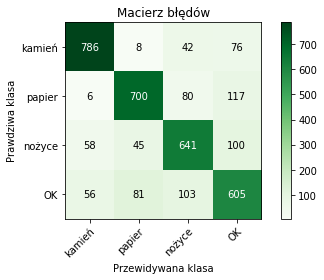

In [49]:
dtc = DecisionTreeClassifier(max_depth=18, criterion='entropy')

dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
result = dtc.score(x_test, y_test)

target_names=['kamień','papier','nożyce','OK']

print("Sprawność: ", result, "\n" )
print(classification_report(y_test, y_pred, target_names=target_names))
view_confusion_matrix(y_test, y_pred, classes=target_names)

plt.show()

## Wnioski

Proszę ocenić czy do poprawnej klasyfikacji należy wykorzystać wszystkie atrybuty, czy wystarczy ich podzbiór, a może należy stworzyć jakieś nowe dane w oparciu o istniejące